# Models 3 
Here we will use the best model from the previous notebook and try to imporve it.
Also we will see how the model performs removing electrodes from the input.

All the helper functions are now stored in the utils folder, so we can import them easily and focus on the models tuning.

In [35]:
from utils.model_utils import *
from utils.model_plots import *
import sys
from importlib import reload
reload(sys.modules['utils.model_utils'])
reload(sys.modules['utils.model_plots'])
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
from EEGDataset import EEGDataset
# Dataset object
eeg_dataset = EEGDataset('SynapSee_data.json', subjects_to_include=['mateo', 'pato2'])
print(len(eeg_dataset))
train_dataset, val_dataset = stratified_split(eeg_dataset, stratify_by='class')
batch_size = 15
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

2358


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
class EEGSuperConv(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(EEGSuperConv, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        # Adaptive pooling to make it size-independent
        self.adap_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        
        # transpose the input to match the expected format
        x = x.transpose(1, 2)
        
        # Applying convolutional layers with ReLU activations and pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool1d(x, 2)

        # Adaptive pooling and flattening
        x = self.adap_pool(x)
        x = torch.flatten(x, 1)

        # Fully connected layer for classification
        x = self.fc(x)

        return x

## Best model, Mateo & Pato, all channels

Epoch [1/2000], Train Loss: 102.2665, Train Accuracy: 0.2540, Validation Loss: 13.7130, Validation Accuracy: 0.2373
Epoch [101/2000], Train Loss: 1.2944, Train Accuracy: 0.5631, Validation Loss: 1.9377, Validation Accuracy: 0.4428
Epoch [201/2000], Train Loss: 1.0460, Train Accuracy: 0.6490, Validation Loss: 0.6465, Validation Accuracy: 0.7924
Epoch [301/2000], Train Loss: 0.8021, Train Accuracy: 0.6983, Validation Loss: 1.0159, Validation Accuracy: 0.6504
Early stopping triggered
Epoch [369/2000], Train Loss: 0.6739, Train Accuracy: 0.7572, Validation Loss: 0.6821, Validation Accuracy: 0.8030


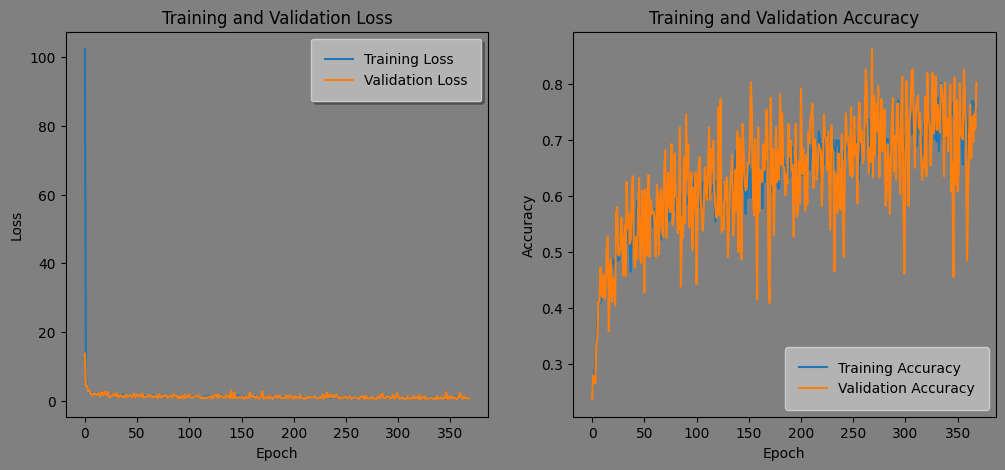

Total correct predictions: 1491/1886
Overall accuracy: 0.7906
Correct predictions for cat: 472/474; Accuracy: 0.9958
Correct predictions for dog: 383/474; Accuracy: 0.8080
Correct predictions for rabbit: 377/471; Accuracy: 0.8004
Correct predictions for control: 259/467; Accuracy: 0.5546


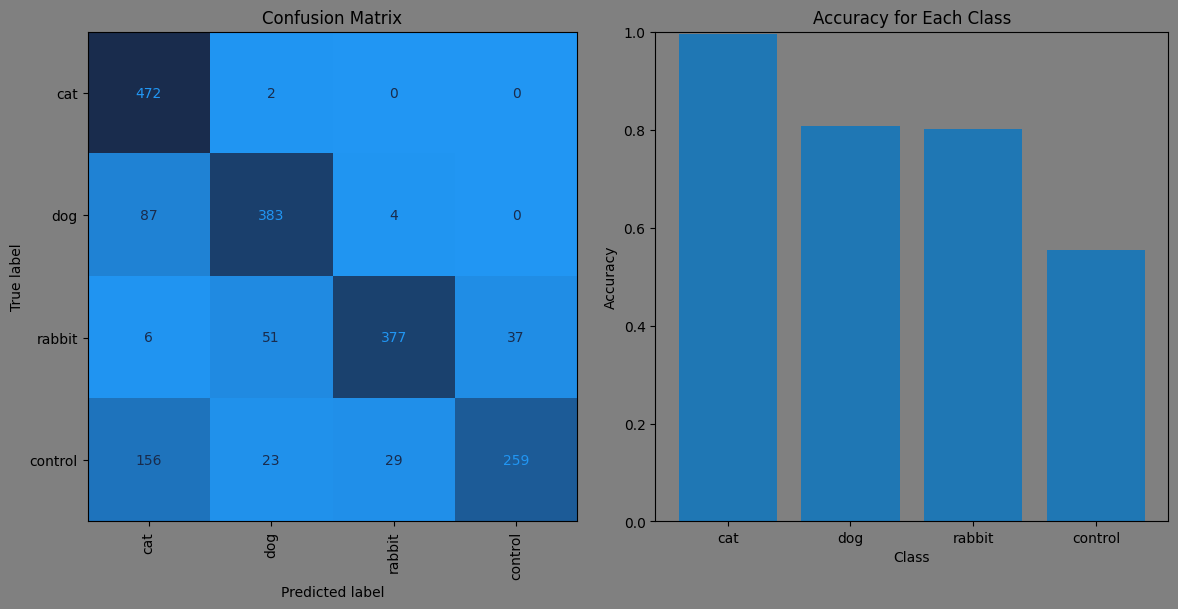

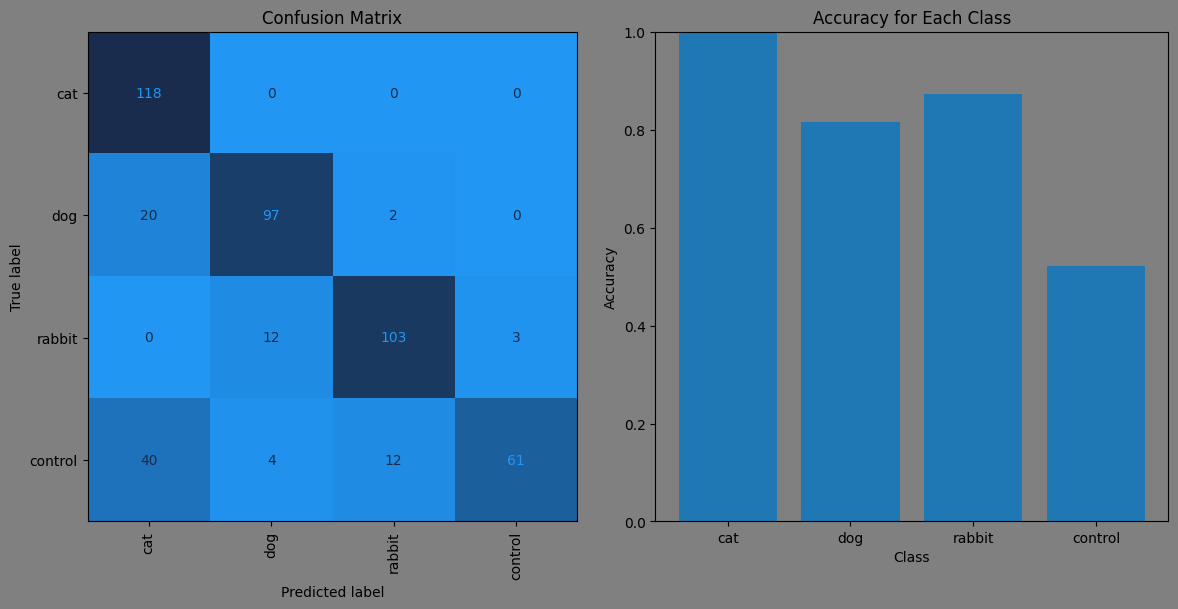

In [6]:
eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(eegsuperconv.parameters(), lr=0.0001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(eegsuperconv, 
                                                                        train_loader, 
                                                                        val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=1000, 
                                                                        patience=100, 
                                                                        verbose=100)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(eegsuperconv, train_loader, device,
                        class_names=eeg_dataset.class_mapping.keys())

# Evaluate the model on the validation set
evaluate_class_metrics(eegsuperconv, val_loader, device, print_metrics=False,
                        class_names=eeg_dataset.class_mapping.keys())

## Best model, Mateo & Pato, removing oxipital channels

Epoch [1/1000], Train Loss: 68.3592, Train Accuracy: 0.2641, Validation Loss: 6.7556, Validation Accuracy: 0.2775
Epoch [101/1000], Train Loss: 2.4856, Train Accuracy: 0.4327, Validation Loss: 1.4471, Validation Accuracy: 0.4619
Epoch [201/1000], Train Loss: 2.0442, Train Accuracy: 0.4862, Validation Loss: 4.0326, Validation Accuracy: 0.3708
Epoch [301/1000], Train Loss: 1.8136, Train Accuracy: 0.5255, Validation Loss: 1.3237, Validation Accuracy: 0.5953
Early stopping triggered
Epoch [388/1000], Train Loss: 1.9689, Train Accuracy: 0.5382, Validation Loss: 0.8030, Validation Accuracy: 0.7097


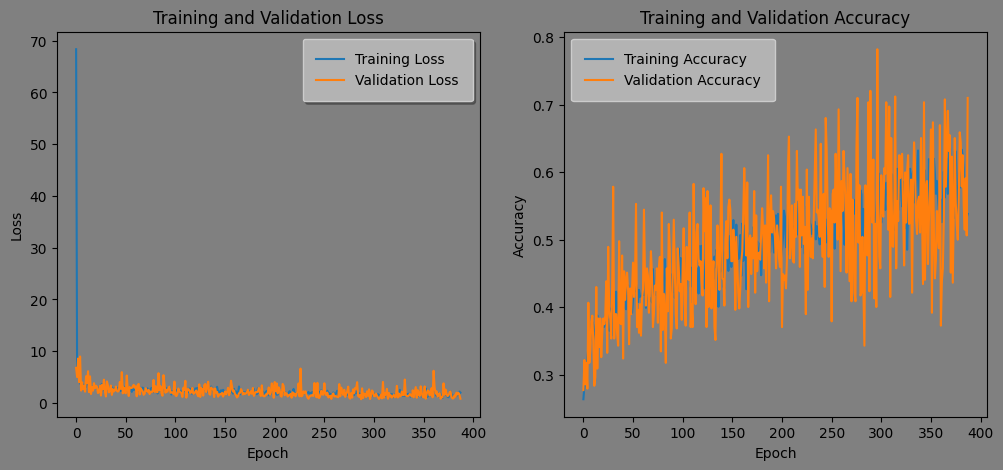

Total correct predictions: 1368/1886
Overall accuracy: 0.7253
Correct predictions for cat: 394/474; Accuracy: 0.8312
Correct predictions for dog: 321/474; Accuracy: 0.6772
Correct predictions for rabbit: 361/471; Accuracy: 0.7665
Correct predictions for control: 292/467; Accuracy: 0.6253


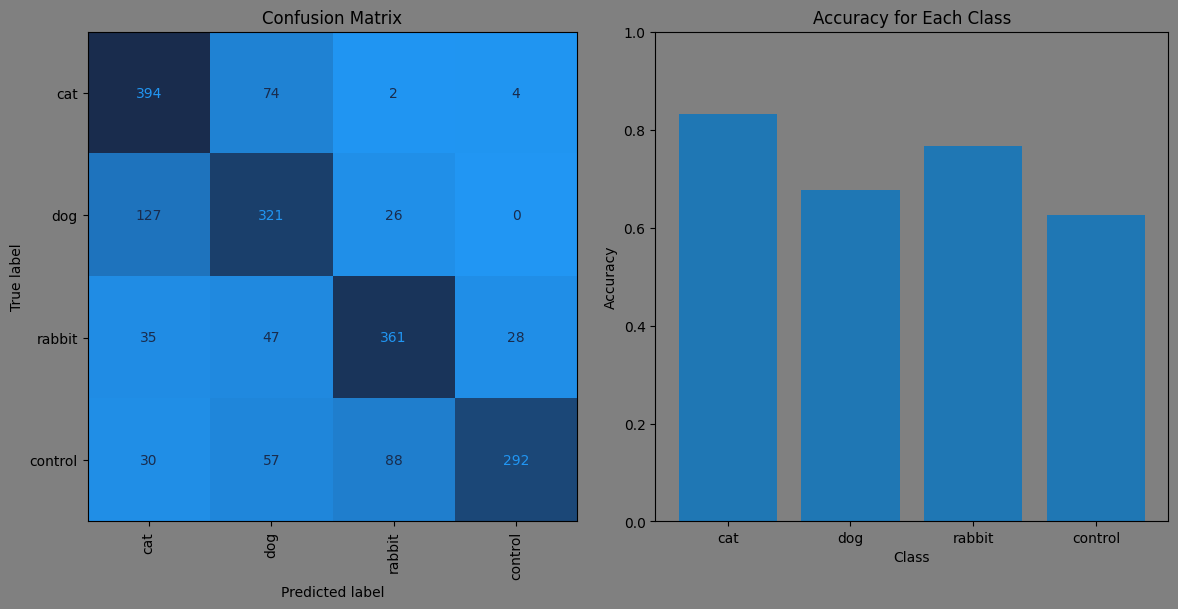

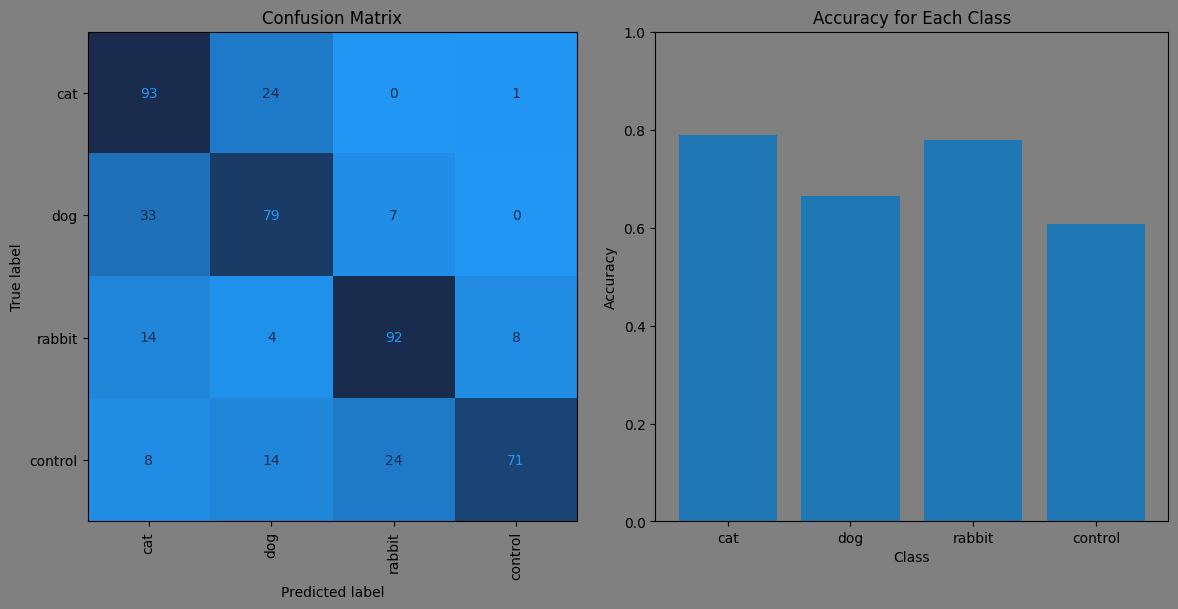

In [38]:
channels_to_include2 = [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15]

eegsuperconv2 = EEGSuperConv(num_channels=len(channels_to_include2), num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(eegsuperconv2.parameters(), lr=0.00001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(eegsuperconv2, 
                                                                        train_loader, 
                                                                        val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=1000, 
                                                                        patience=100, 
                                                                        verbose=100,
                                                                        channels_to_include=channels_to_include2)


# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(eegsuperconv2, train_loader, device, channels_to_include=channels_to_include2,
                        class_names=eeg_dataset.class_mapping.keys())

# Evaluate the model on the validation set
evaluate_class_metrics(eegsuperconv2, val_loader, device, print_metrics=False, channels_to_include=channels_to_include2,
                        class_names=eeg_dataset.class_mapping.keys())

## Best model, Mateo & Pato, only visual related channels

Epoch [1/1000], Train Loss: 41.2172, Train Accuracy: 0.2529, Validation Loss: 11.4006, Validation Accuracy: 0.2712
Epoch [101/1000], Train Loss: 2.6725, Train Accuracy: 0.3595, Validation Loss: 2.9015, Validation Accuracy: 0.3771
Early stopping triggered
Epoch [170/1000], Train Loss: 2.9634, Train Accuracy: 0.3786, Validation Loss: 2.6484, Validation Accuracy: 0.3411


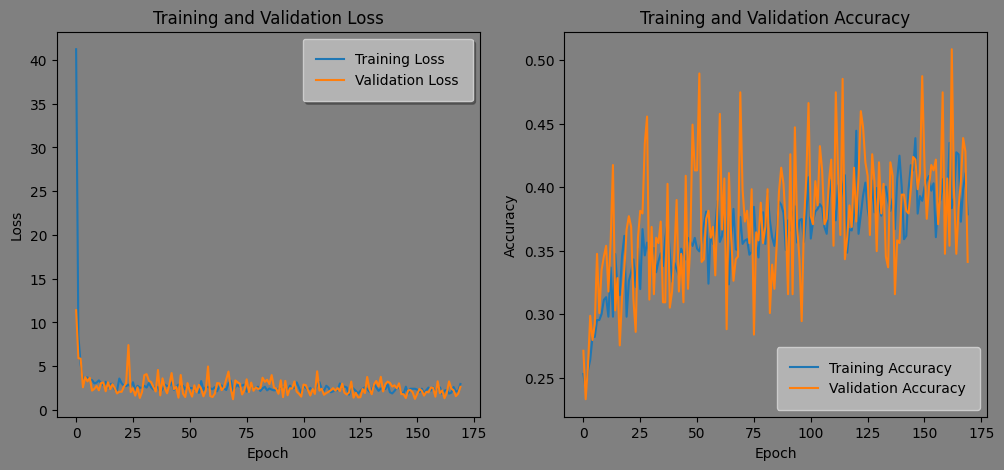

Total correct predictions: 625/1886
Overall accuracy: 0.3314
Correct predictions for cat: 397/474; Accuracy: 0.8376
Correct predictions for dog: 34/474; Accuracy: 0.0717
Correct predictions for rabbit: 28/471; Accuracy: 0.0594
Correct predictions for control: 166/467; Accuracy: 0.3555


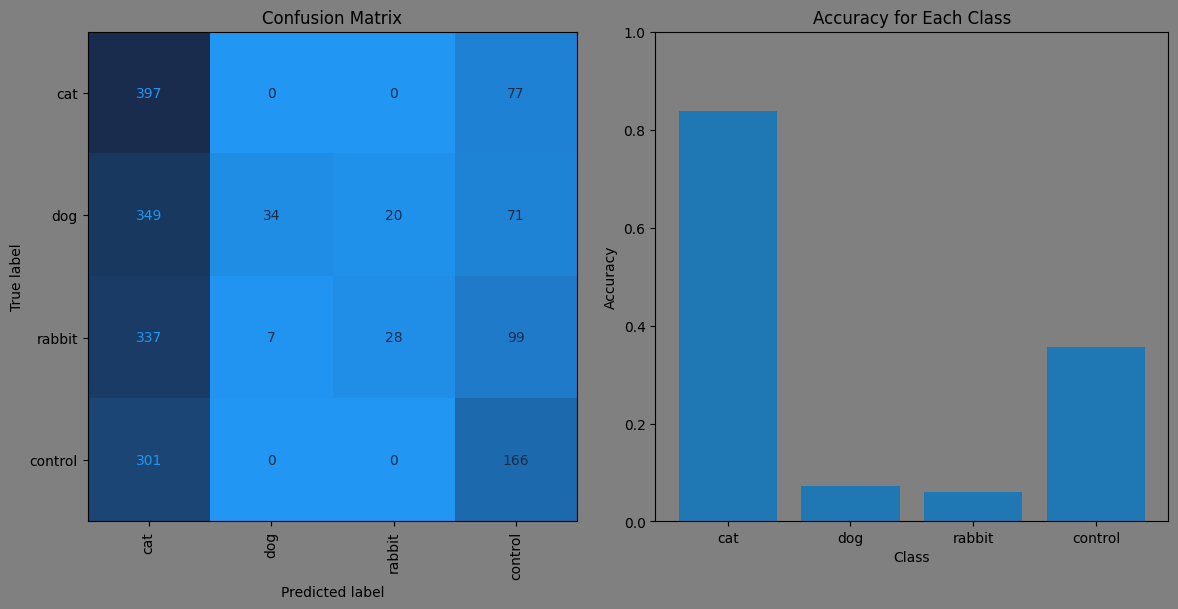

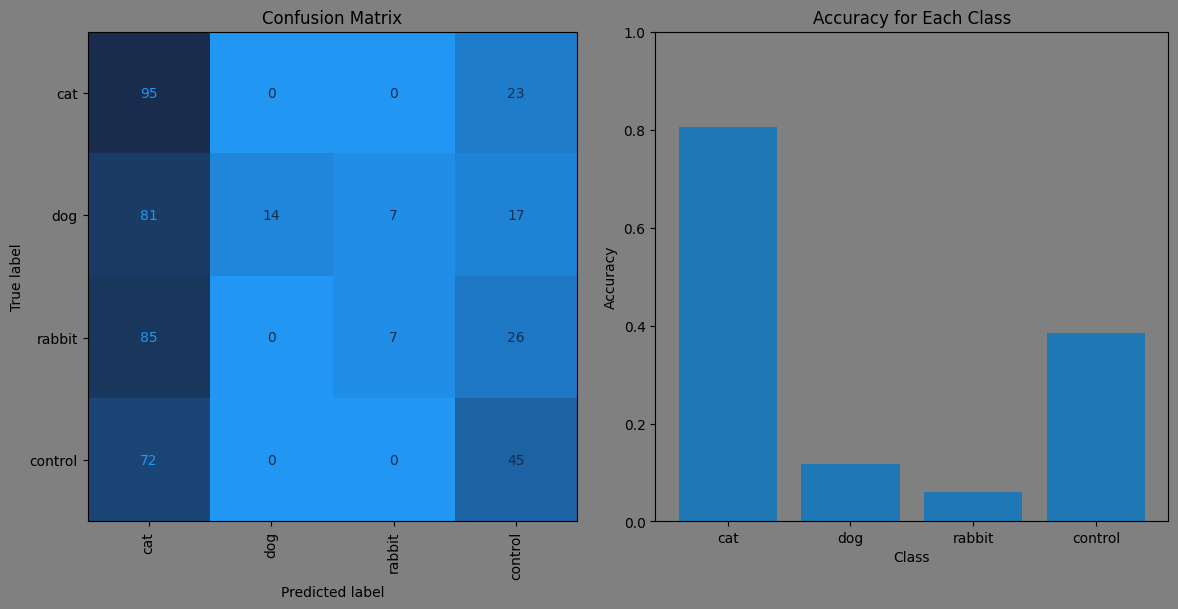

In [39]:
channels_to_include3 = [4, 5, 6, 7, 14, 15]

eegsuperconv3 = EEGSuperConv(num_channels=len(channels_to_include3), num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(eegsuperconv3.parameters(), lr=0.00001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(eegsuperconv3, 
                                                                        train_loader, 
                                                                        val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=1000, 
                                                                        patience=100, 
                                                                        verbose=100,
                                                                        channels_to_include=channels_to_include3)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(eegsuperconv3, train_loader, device, channels_to_include=channels_to_include3,
                        class_names=eeg_dataset.class_mapping.keys())

# Evaluate the model on the validation set
evaluate_class_metrics(eegsuperconv3, val_loader, device, print_metrics=False, channels_to_include=channels_to_include3,
                        class_names=eeg_dataset.class_mapping.keys())

## Same tests but with mateo, pato, andy and muri data

In [40]:
# Dataset object
full_eeg_dataset = EEGDataset('SynapSee_data.json', subjects_to_include=['mateo', 'pato2', 'andy', 'muri'])
print(len(full_eeg_dataset))
full_train_dataset, full_val_dataset = stratified_split(full_eeg_dataset, stratify_by='class')
batch_size = 15
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
full_val_loader = DataLoader(full_val_dataset, batch_size=batch_size, shuffle=True)

4745


----------------- ALL CHANNELS -----------------
Epoch [1/1000], Train Loss: 50.8745, Train Accuracy: 0.2471, Validation Loss: 15.0770, Validation Accuracy: 0.2540
Epoch [101/1000], Train Loss: 2.6696, Train Accuracy: 0.4816, Validation Loss: 4.4853, Validation Accuracy: 0.3604
Epoch [201/1000], Train Loss: 1.9192, Train Accuracy: 0.5743, Validation Loss: 1.6670, Validation Accuracy: 0.5627
Epoch [301/1000], Train Loss: 1.4164, Train Accuracy: 0.6159, Validation Loss: 2.3171, Validation Accuracy: 0.4879
Epoch [401/1000], Train Loss: 1.4235, Train Accuracy: 0.6312, Validation Loss: 2.2987, Validation Accuracy: 0.5258
Epoch [501/1000], Train Loss: 1.0264, Train Accuracy: 0.7089, Validation Loss: 1.3203, Validation Accuracy: 0.6470
Epoch [601/1000], Train Loss: 0.8975, Train Accuracy: 0.7271, Validation Loss: 1.1460, Validation Accuracy: 0.6712
Epoch [701/1000], Train Loss: 0.5785, Train Accuracy: 0.7895, Validation Loss: 0.9461, Validation Accuracy: 0.7071
Epoch [801/1000], Train Loss: 0

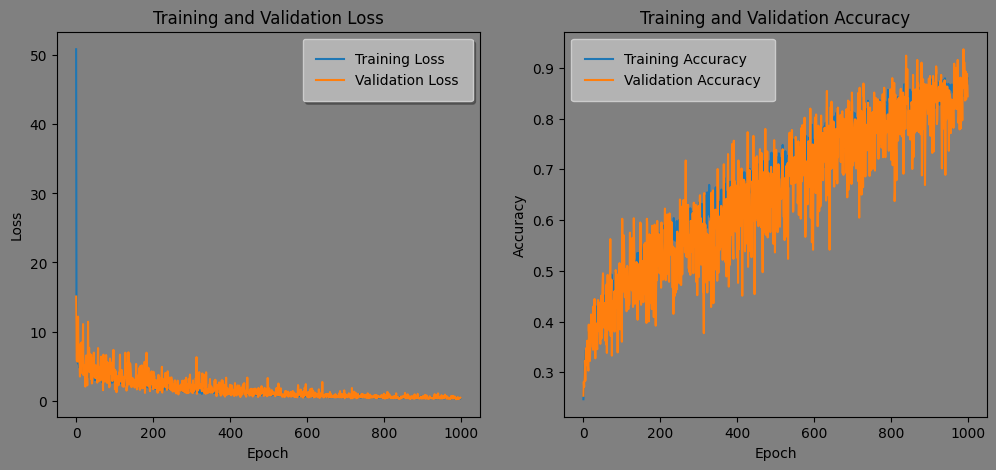

Total correct predictions: 3190/3796
Overall accuracy: 0.8404
Correct predictions for cat: 654/950; Accuracy: 0.6884
Correct predictions for dog: 873/953; Accuracy: 0.9161
Correct predictions for rabbit: 759/950; Accuracy: 0.7989
Correct predictions for control: 904/943; Accuracy: 0.9586


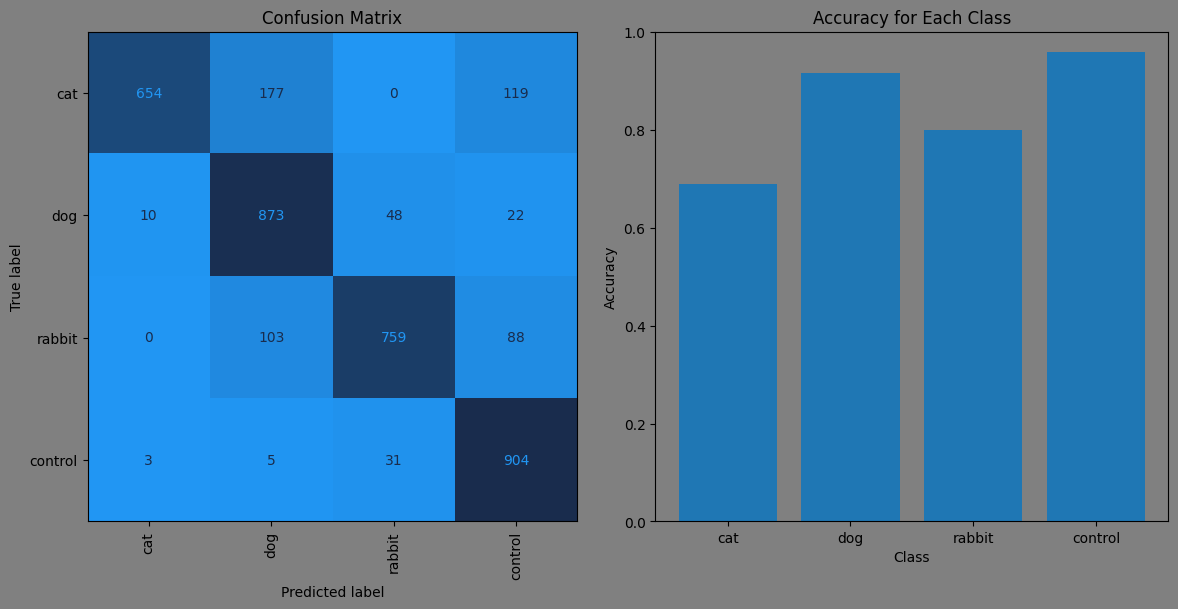

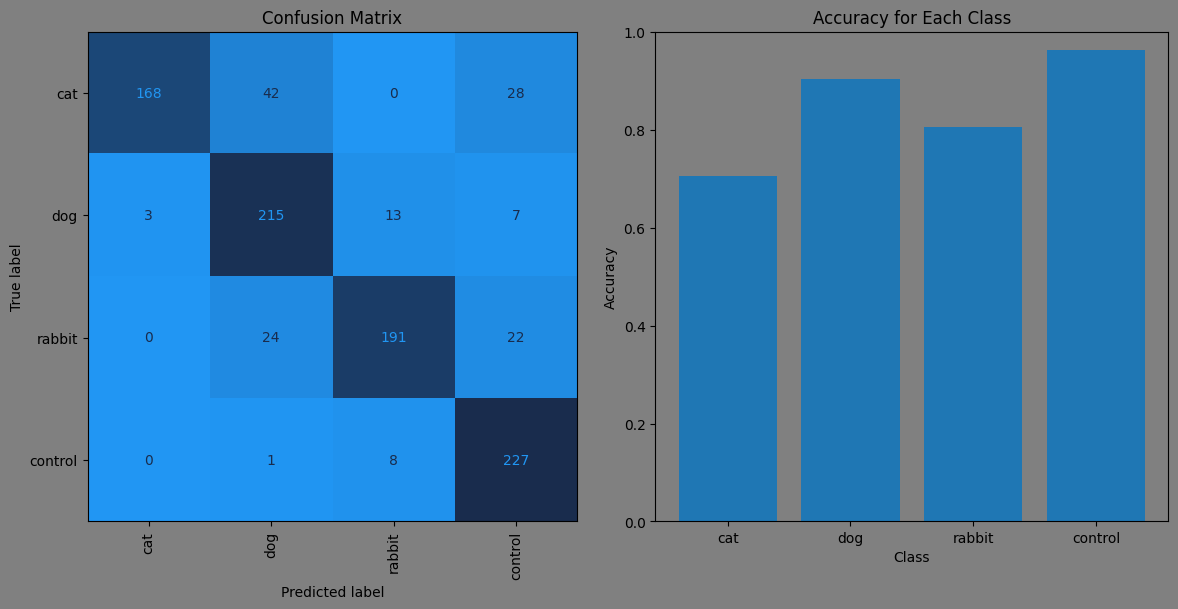

----------------- NO OXIPITAL CHANNELS -----------------
Epoch [1/1000], Train Loss: 99.3756, Train Accuracy: 0.2395, Validation Loss: 11.7800, Validation Accuracy: 0.2202
Epoch [101/1000], Train Loss: 2.3499, Train Accuracy: 0.4813, Validation Loss: 4.5991, Validation Accuracy: 0.4679
Epoch [201/1000], Train Loss: 2.1236, Train Accuracy: 0.5087, Validation Loss: 3.7139, Validation Accuracy: 0.4531
Epoch [301/1000], Train Loss: 1.4945, Train Accuracy: 0.5869, Validation Loss: 1.3320, Validation Accuracy: 0.6143
Epoch [401/1000], Train Loss: 1.3693, Train Accuracy: 0.6267, Validation Loss: 1.0759, Validation Accuracy: 0.6691
Epoch [501/1000], Train Loss: 1.2092, Train Accuracy: 0.6407, Validation Loss: 0.9000, Validation Accuracy: 0.7071
Epoch [601/1000], Train Loss: 0.9728, Train Accuracy: 0.7036, Validation Loss: 2.2809, Validation Accuracy: 0.5205
Epoch [701/1000], Train Loss: 0.6443, Train Accuracy: 0.7721, Validation Loss: 0.6230, Validation Accuracy: 0.7397
Epoch [801/1000], Train

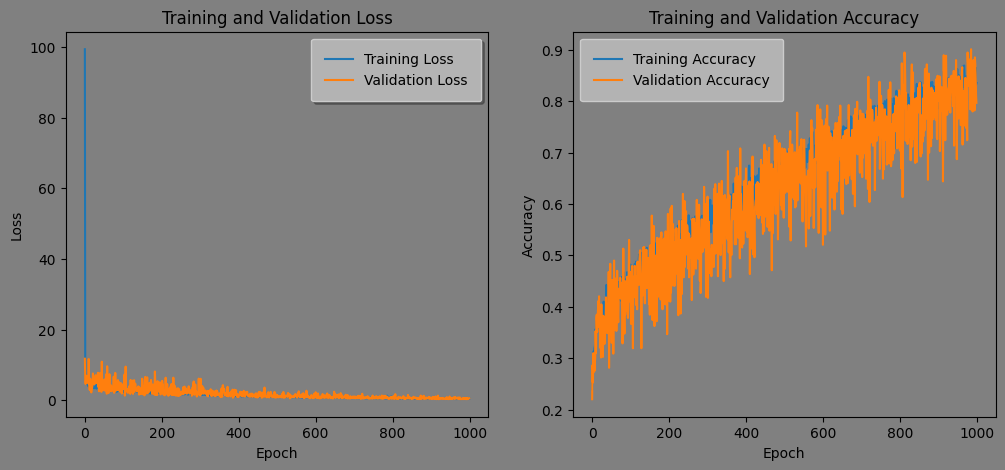

Total correct predictions: 3025/3796
Overall accuracy: 0.7969
Correct predictions for cat: 588/950; Accuracy: 0.6189
Correct predictions for dog: 887/953; Accuracy: 0.9307
Correct predictions for rabbit: 694/950; Accuracy: 0.7305
Correct predictions for control: 856/943; Accuracy: 0.9077


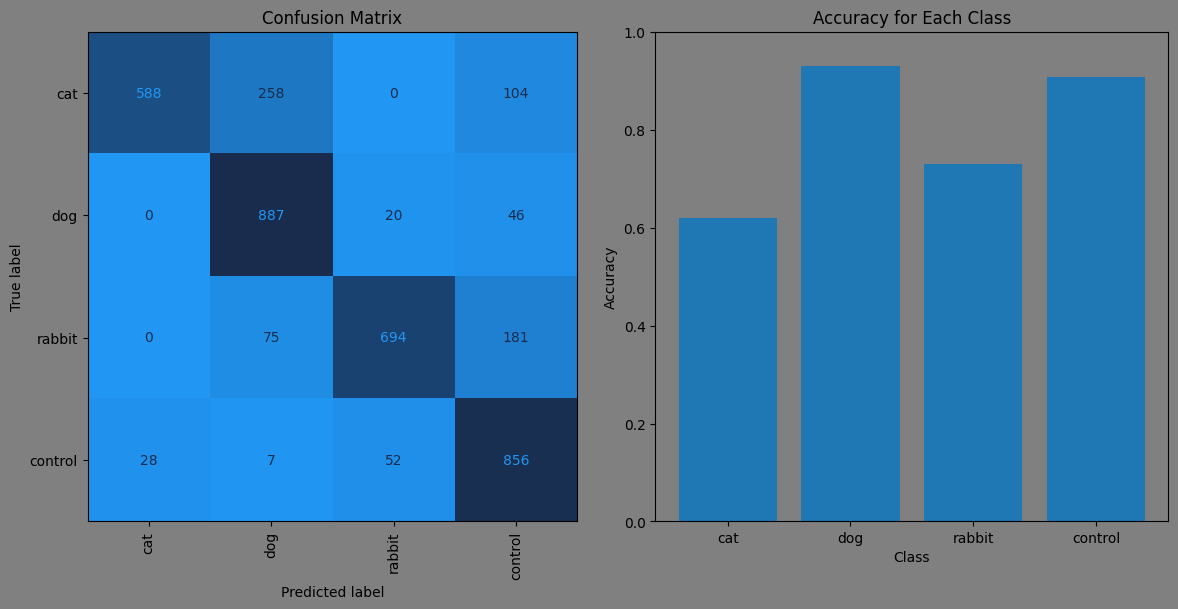

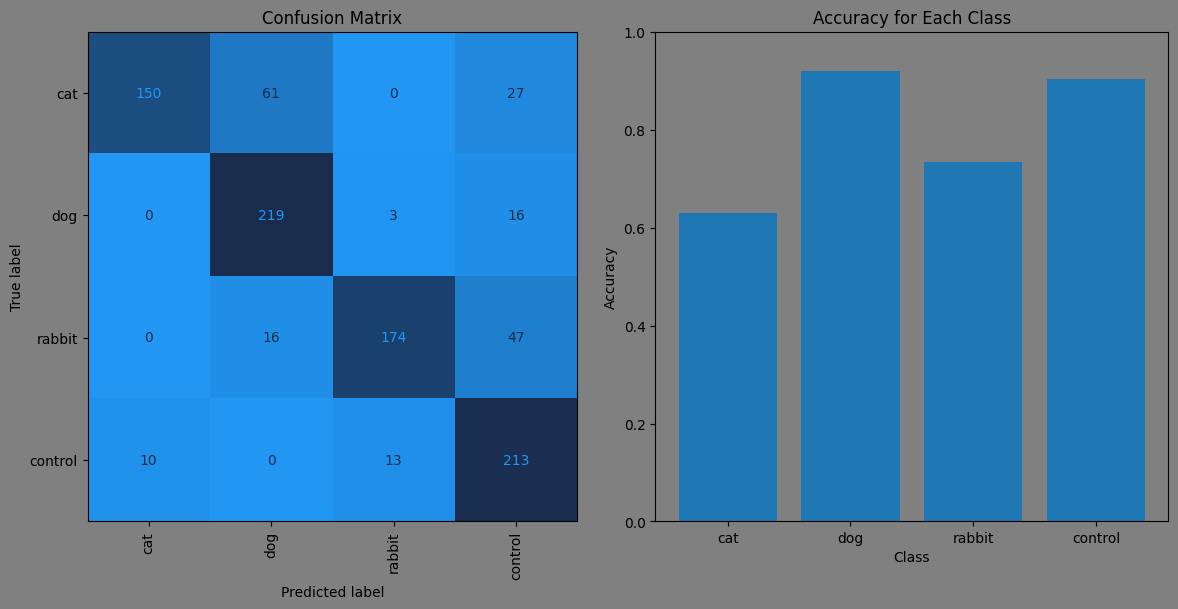

----------------- ONLY VISUAL CHANNELS -----------------
Epoch [1/1000], Train Loss: 82.6193, Train Accuracy: 0.2561, Validation Loss: 16.7838, Validation Accuracy: 0.2603
Epoch [101/1000], Train Loss: 3.5052, Train Accuracy: 0.4615, Validation Loss: 4.3342, Validation Accuracy: 0.4089
Epoch [201/1000], Train Loss: 3.4827, Train Accuracy: 0.4910, Validation Loss: 5.3035, Validation Accuracy: 0.4563
Epoch [301/1000], Train Loss: 2.6140, Train Accuracy: 0.5119, Validation Loss: 3.6627, Validation Accuracy: 0.4816
Epoch [401/1000], Train Loss: 2.1574, Train Accuracy: 0.5306, Validation Loss: 4.5234, Validation Accuracy: 0.4689
Epoch [501/1000], Train Loss: 1.4727, Train Accuracy: 0.5587, Validation Loss: 3.5953, Validation Accuracy: 0.4805
Epoch [601/1000], Train Loss: 1.4057, Train Accuracy: 0.5653, Validation Loss: 1.5680, Validation Accuracy: 0.6006
Epoch [701/1000], Train Loss: 1.3051, Train Accuracy: 0.5880, Validation Loss: 1.7934, Validation Accuracy: 0.5100
Epoch [801/1000], Train

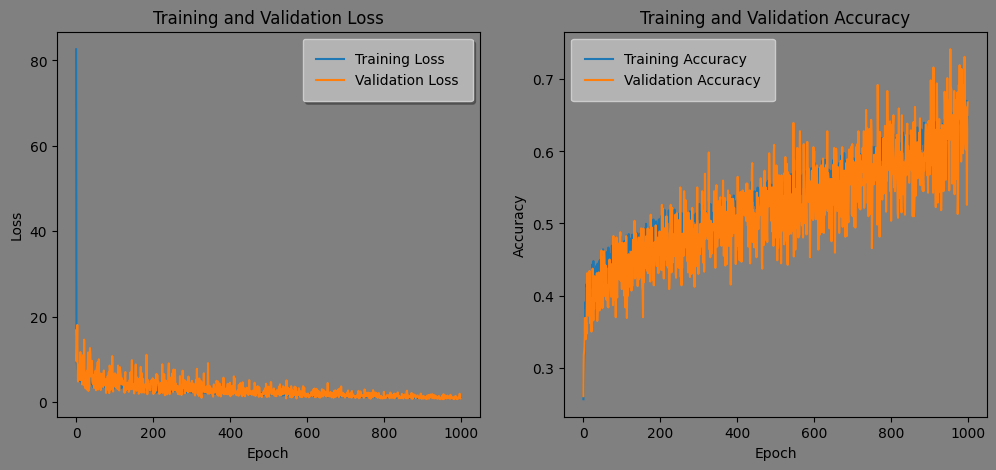

Total correct predictions: 2504/3796
Overall accuracy: 0.6596
Correct predictions for cat: 929/950; Accuracy: 0.9779
Correct predictions for dog: 554/953; Accuracy: 0.5813
Correct predictions for rabbit: 673/950; Accuracy: 0.7084
Correct predictions for control: 348/943; Accuracy: 0.3690


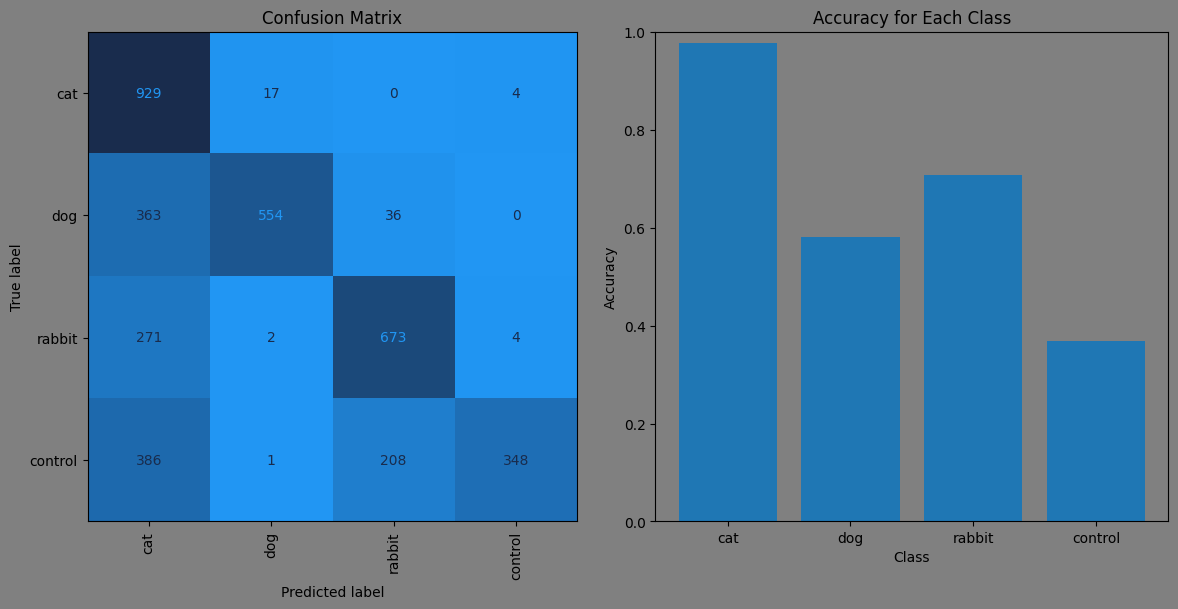

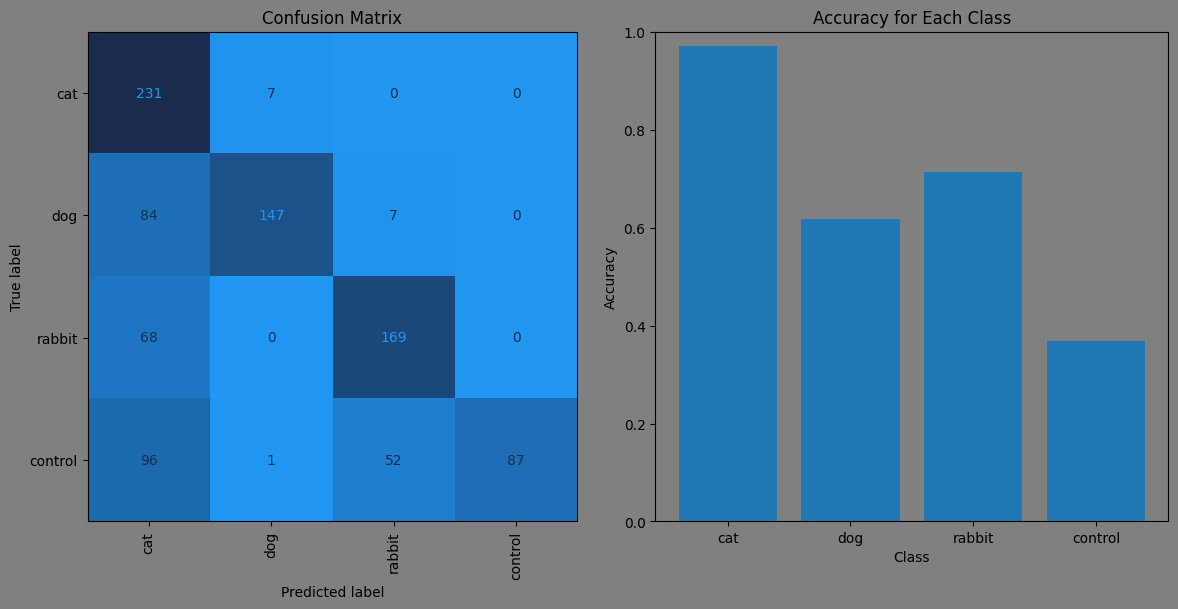

In [41]:
# Loss function
criterion = nn.CrossEntropyLoss()

EPOCHS = 1000
PATIENCE = -1
VERBOSE = 100
LR = 0.00001

print("----------------- ALL CHANNELS -----------------")

full_eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)

# Optimizer
optimizer = optim.Adam(full_eegsuperconv.parameters(), lr=LR)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(full_eegsuperconv, 
                                                                        full_train_loader, 
                                                                        full_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=EPOCHS, 
                                                                        patience=PATIENCE, 
                                                                        verbose=VERBOSE)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(full_eegsuperconv, full_train_loader, device,
                        class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(full_eegsuperconv, full_val_loader, device, print_metrics=False,
                        class_names=full_eeg_dataset.class_mapping.keys())

print("----------------- NO OXIPITAL CHANNELS -----------------")

channels_to_include4 = [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15]

full_eegsuperconv2 = EEGSuperConv(num_channels=len(channels_to_include4), num_classes=4).to(device)

# Optimizer
optimizer = optim.Adam(full_eegsuperconv2.parameters(), lr=LR)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(full_eegsuperconv2, 
                                                                        full_train_loader, 
                                                                        full_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=EPOCHS, 
                                                                        patience=PATIENCE, 
                                                                        verbose=VERBOSE,
                                                                        channels_to_include=channels_to_include4)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(full_eegsuperconv2, full_train_loader, device, channels_to_include=channels_to_include4,
                        class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(full_eegsuperconv2, full_val_loader, device, print_metrics=False, channels_to_include=channels_to_include4,
                        class_names=full_eeg_dataset.class_mapping.keys())

print("----------------- ONLY VISUAL CHANNELS -----------------")

channels_to_include5 = [4, 5, 6, 7, 14, 15]

full_eegsuperconv3 = EEGSuperConv(num_channels=len(channels_to_include5), num_classes=4).to(device)

# Optimizer
optimizer = optim.Adam(full_eegsuperconv3.parameters(), lr=LR)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(full_eegsuperconv3, 
                                                                        full_train_loader, 
                                                                        full_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=EPOCHS, 
                                                                        patience=PATIENCE, 
                                                                        verbose=VERBOSE,
                                                                        channels_to_include=channels_to_include5)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(full_eegsuperconv3, full_train_loader, device, channels_to_include=channels_to_include5,
                        class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(full_eegsuperconv3, full_val_loader, device, print_metrics=False, channels_to_include=channels_to_include5,
                        class_names=full_eeg_dataset.class_mapping.keys())


----------------- ALL CHANNELS -----------------
Epoch [1/200], Train Loss: 34.5248, Train Accuracy: 0.2568, Validation Loss: 36.9894, Validation Accuracy: 0.2687
Epoch [101/200], Train Loss: 0.4324, Train Accuracy: 0.8311, Validation Loss: 0.4295, Validation Accuracy: 0.8209
Epoch [200/200], Train Loss: 0.2680, Train Accuracy: 0.8917, Validation Loss: 0.2445, Validation Accuracy: 0.8957


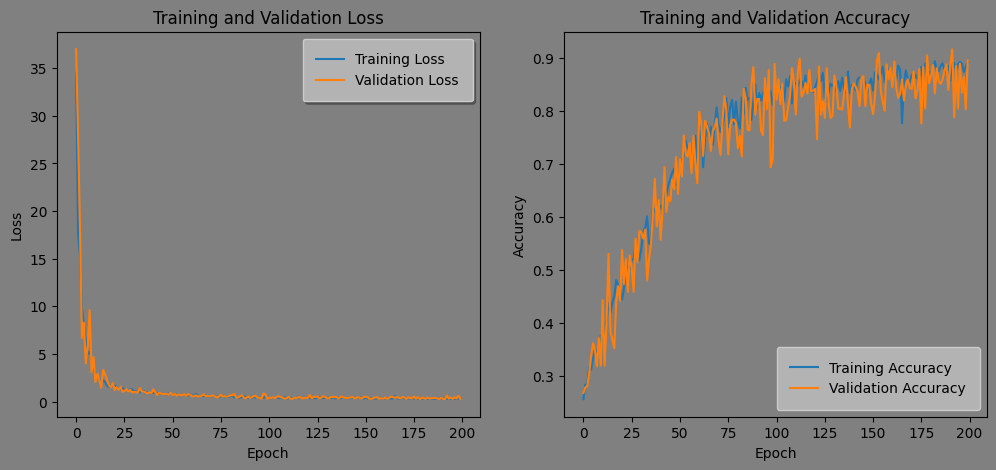

Total correct predictions: 3479/3796
Overall accuracy: 0.9165
Correct predictions for cat: 866/950; Accuracy: 0.9116
Correct predictions for dog: 864/953; Accuracy: 0.9066
Correct predictions for rabbit: 860/950; Accuracy: 0.9053
Correct predictions for control: 889/943; Accuracy: 0.9427


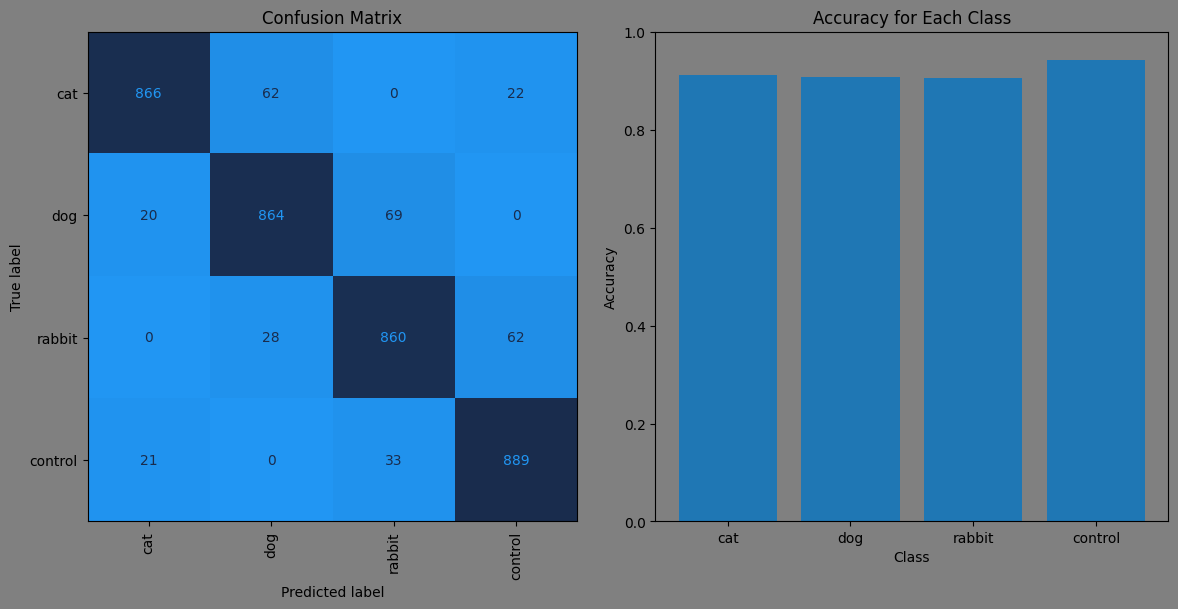

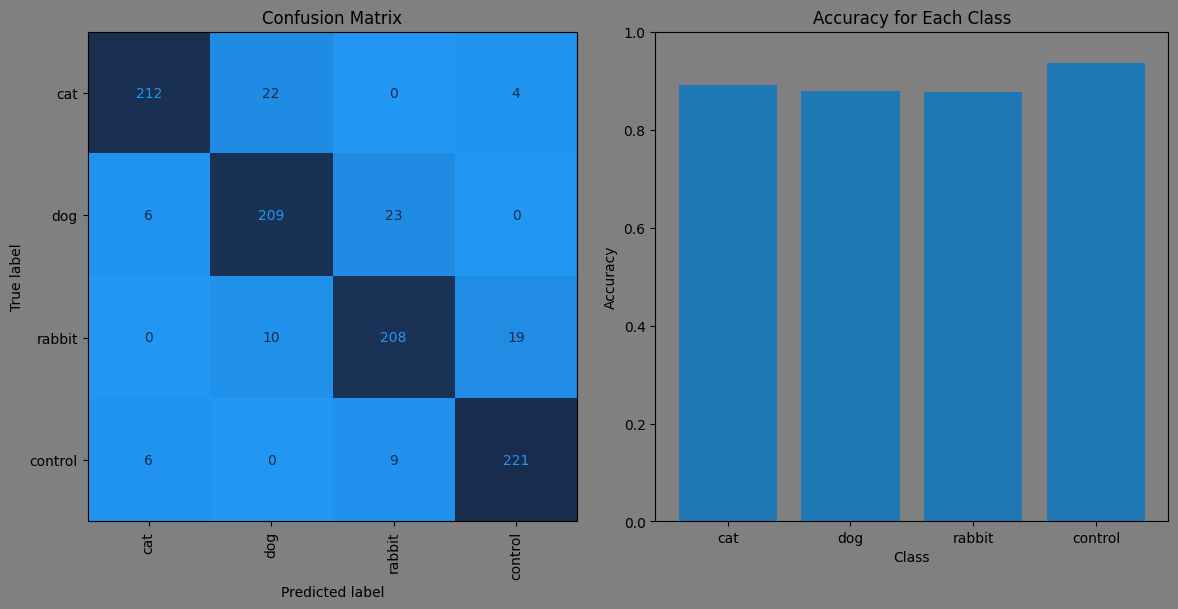

----------------- NO OXIPITAL CHANNELS -----------------
Epoch [1/200], Train Loss: 36.1705, Train Accuracy: 0.2595, Validation Loss: 31.9731, Validation Accuracy: 0.2550
Epoch [101/200], Train Loss: 0.8649, Train Accuracy: 0.5954, Validation Loss: 0.7961, Validation Accuracy: 0.6101
Epoch [200/200], Train Loss: 0.7719, Train Accuracy: 0.6423, Validation Loss: 0.7013, Validation Accuracy: 0.6491


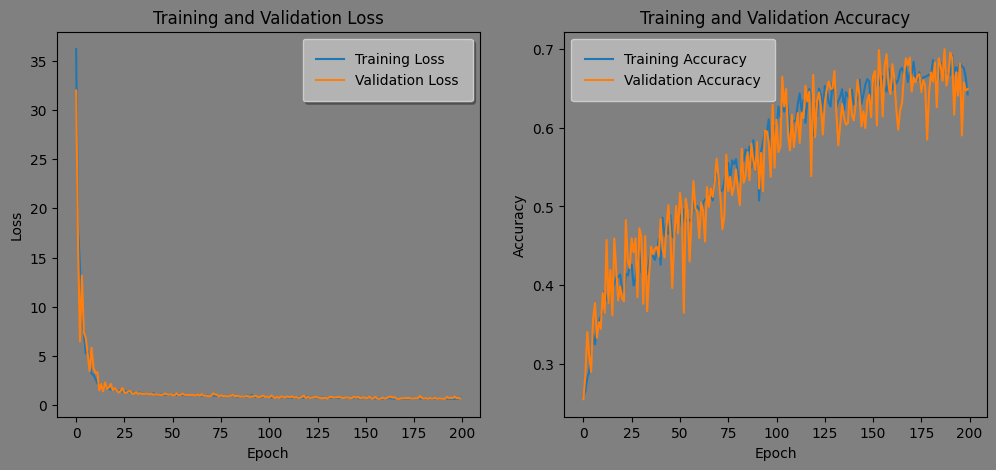

Total correct predictions: 2548/3796
Overall accuracy: 0.6712
Correct predictions for cat: 634/950; Accuracy: 0.6674
Correct predictions for dog: 567/953; Accuracy: 0.5950
Correct predictions for rabbit: 811/950; Accuracy: 0.8537
Correct predictions for control: 536/943; Accuracy: 0.5684


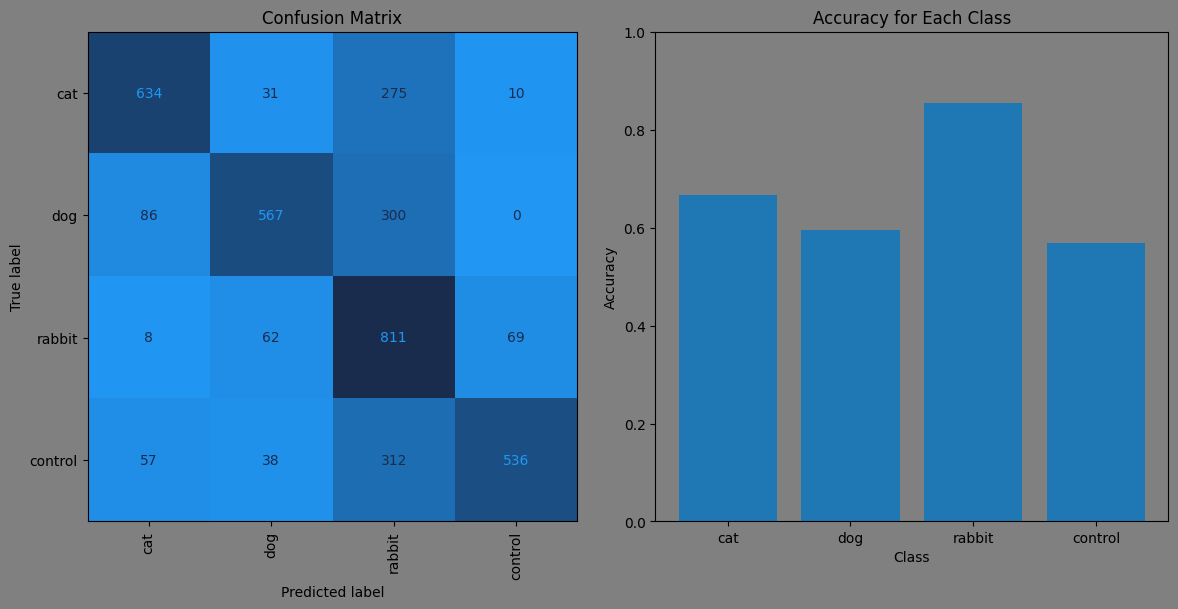

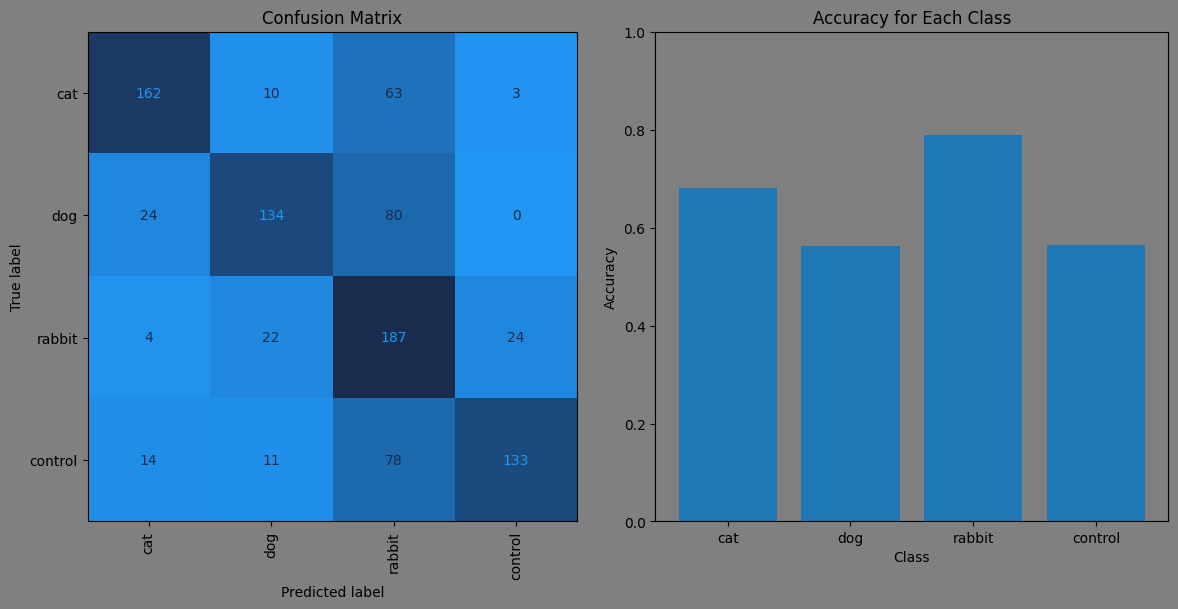

----------------- ONLY VISUAL CHANNELS -----------------
Epoch [1/200], Train Loss: 27.3891, Train Accuracy: 0.2774, Validation Loss: 25.6927, Validation Accuracy: 0.3182
Epoch [101/200], Train Loss: 0.7810, Train Accuracy: 0.6204, Validation Loss: 0.7652, Validation Accuracy: 0.6554
Epoch [200/200], Train Loss: 0.6028, Train Accuracy: 0.7155, Validation Loss: 0.9167, Validation Accuracy: 0.6407


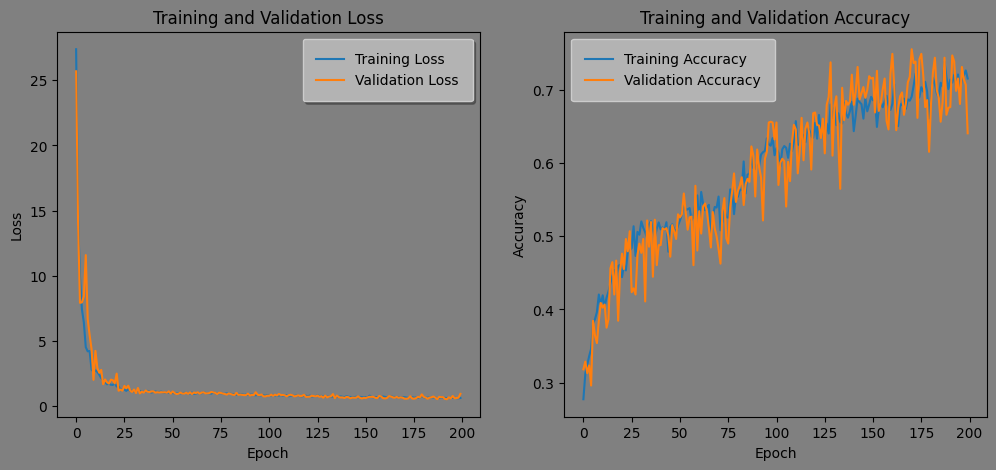

Total correct predictions: 2424/3796
Overall accuracy: 0.6386
Correct predictions for cat: 670/950; Accuracy: 0.7053
Correct predictions for dog: 518/953; Accuracy: 0.5435
Correct predictions for rabbit: 470/950; Accuracy: 0.4947
Correct predictions for control: 766/943; Accuracy: 0.8123


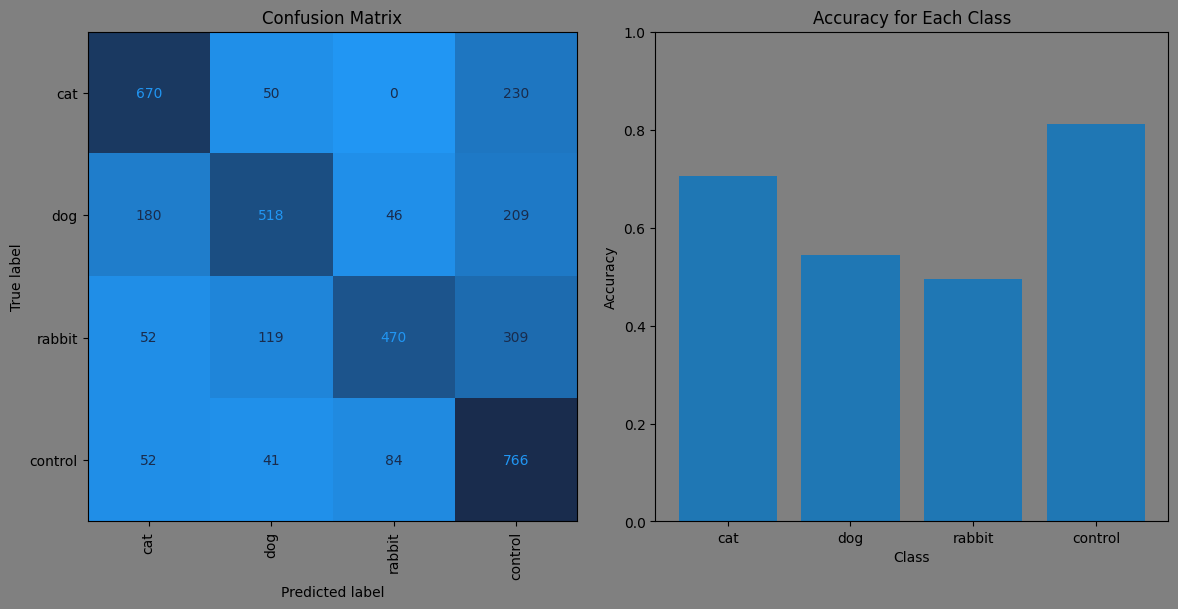

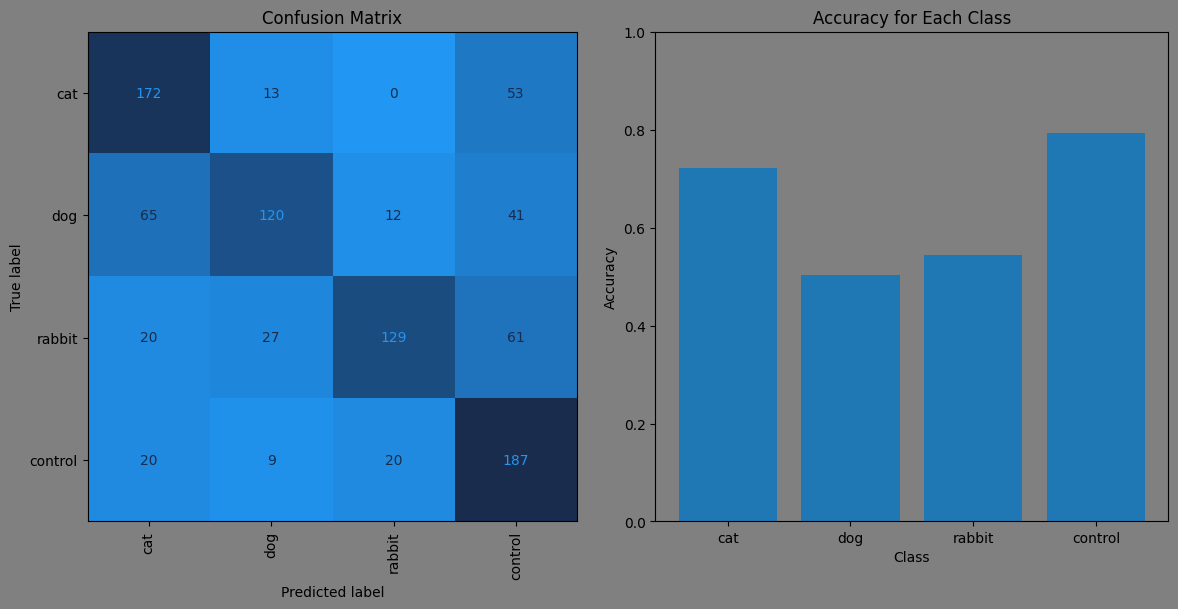

In [44]:
# Loss function
criterion = nn.CrossEntropyLoss()

EPOCHS = 200
PATIENCE = -1
VERBOSE = 100
LR = 0.0001

print("----------------- ALL CHANNELS -----------------")

full_eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)

# Optimizer
optimizer = optim.Adam(full_eegsuperconv.parameters(), lr=LR)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(full_eegsuperconv, 
                                                                        full_train_loader, 
                                                                        full_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=EPOCHS, 
                                                                        patience=PATIENCE, 
                                                                        verbose=VERBOSE)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(full_eegsuperconv, full_train_loader, device,
                        class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(full_eegsuperconv, full_val_loader, device, print_metrics=False,
                        class_names=full_eeg_dataset.class_mapping.keys())

print("----------------- NO OXIPITAL CHANNELS -----------------")

channels_to_include4 = [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15]

full_eegsuperconv2 = EEGSuperConv(num_channels=len(channels_to_include4), num_classes=4).to(device)

# Optimizer
optimizer = optim.Adam(full_eegsuperconv2.parameters(), lr=LR)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(full_eegsuperconv2, 
                                                                        full_train_loader, 
                                                                        full_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=EPOCHS, 
                                                                        patience=PATIENCE, 
                                                                        verbose=VERBOSE,
                                                                        channels_to_include=channels_to_include4)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(full_eegsuperconv2, full_train_loader, device, channels_to_include=channels_to_include4,
                        class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(full_eegsuperconv2, full_val_loader, device, print_metrics=False, channels_to_include=channels_to_include4,
                        class_names=full_eeg_dataset.class_mapping.keys())

print("----------------- ONLY VISUAL CHANNELS -----------------")

channels_to_include5 = [4, 5, 6, 7, 14, 15]

full_eegsuperconv3 = EEGSuperConv(num_channels=len(channels_to_include5), num_classes=4).to(device)

# Optimizer
optimizer = optim.Adam(full_eegsuperconv3.parameters(), lr=LR)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(full_eegsuperconv3, 
                                                                        full_train_loader, 
                                                                        full_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=EPOCHS, 
                                                                        patience=PATIENCE, 
                                                                        verbose=VERBOSE,
                                                                        channels_to_include=channels_to_include5)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(full_eegsuperconv3, full_train_loader, device, channels_to_include=channels_to_include5,
                        class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(full_eegsuperconv3, full_val_loader, device, print_metrics=False, channels_to_include=channels_to_include5,
                        class_names=full_eeg_dataset.class_mapping.keys())


## Train with all the data except one subject

In [42]:
exp3_dataset = EEGDataset('SynapSee_data.json', subjects_to_include=['mateo', 'pato2', 'andy', 'muri'])	
print(len(exp3_dataset))
dani_dataset = EEGDataset('SynapSee_data.json', subjects_to_include=['dani'])
print(len(dani_dataset))
exp3_train_dataset, exp3_val_dataset = stratified_split(exp3_dataset, stratify_by='class')
batch_size = 15
exp3_train_loader = DataLoader(exp3_train_dataset, batch_size=batch_size, shuffle=True)
exp3_val_loader = DataLoader(exp3_val_dataset, batch_size=batch_size, shuffle=True)
dani_loader = DataLoader(dani_dataset, batch_size=batch_size, shuffle=True)

4745
1196


Epoch [1/1000], Train Loss: 29.7135, Train Accuracy: 0.2505, Validation Loss: 11.7107, Validation Accuracy: 0.2424
Epoch [101/1000], Train Loss: 1.9730, Train Accuracy: 0.5153, Validation Loss: 2.1000, Validation Accuracy: 0.4141
Epoch [201/1000], Train Loss: 1.4395, Train Accuracy: 0.5998, Validation Loss: 2.2938, Validation Accuracy: 0.5406
Epoch [301/1000], Train Loss: 0.8236, Train Accuracy: 0.6889, Validation Loss: 0.9452, Validation Accuracy: 0.6744
Epoch [401/1000], Train Loss: 0.9068, Train Accuracy: 0.6989, Validation Loss: 0.6933, Validation Accuracy: 0.7071
Epoch [501/1000], Train Loss: 0.5644, Train Accuracy: 0.7914, Validation Loss: 1.0238, Validation Accuracy: 0.7028
Epoch [601/1000], Train Loss: 0.4283, Train Accuracy: 0.8335, Validation Loss: 0.3641, Validation Accuracy: 0.8377
Epoch [701/1000], Train Loss: 0.6133, Train Accuracy: 0.8101, Validation Loss: 0.5539, Validation Accuracy: 0.7945
Epoch [801/1000], Train Loss: 0.3210, Train Accuracy: 0.8778, Validation Loss: 0

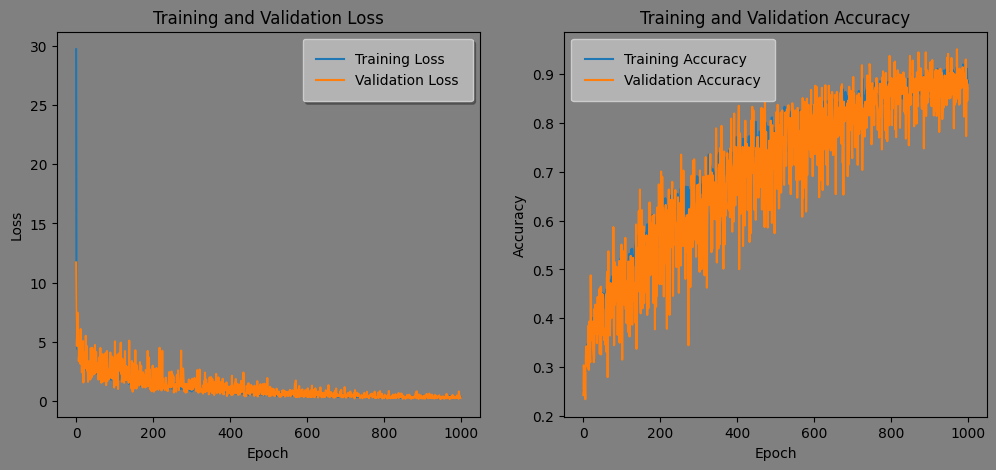

Total correct predictions: 3382/3796
Overall accuracy: 0.8909
Correct predictions for cat: 898/950; Accuracy: 0.9453
Correct predictions for dog: 902/953; Accuracy: 0.9465
Correct predictions for rabbit: 800/950; Accuracy: 0.8421
Correct predictions for control: 782/943; Accuracy: 0.8293


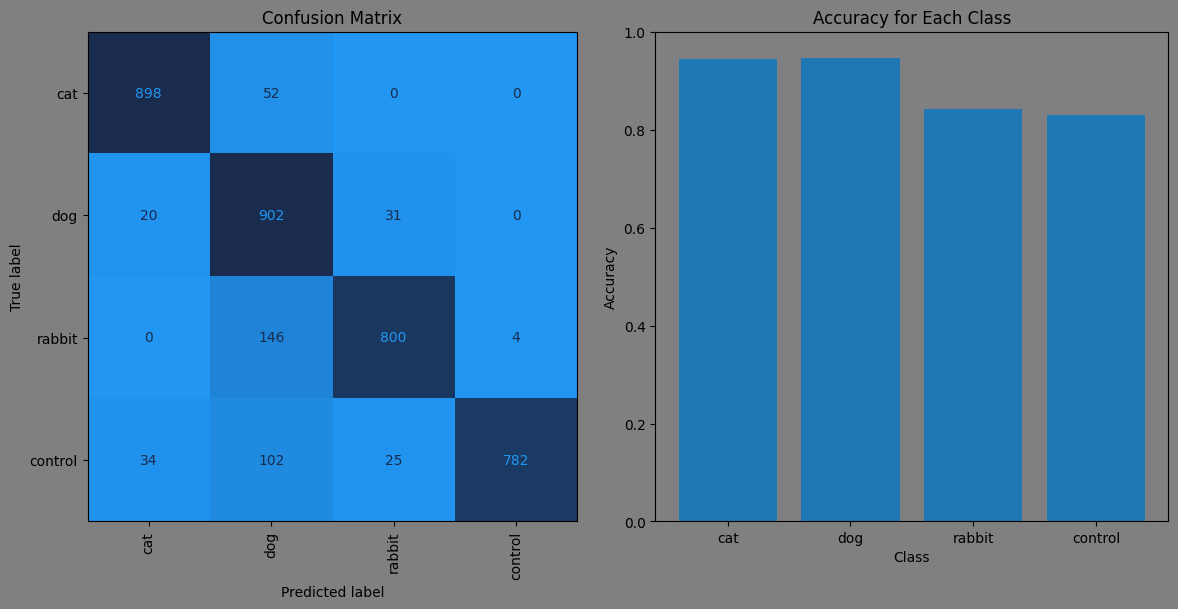

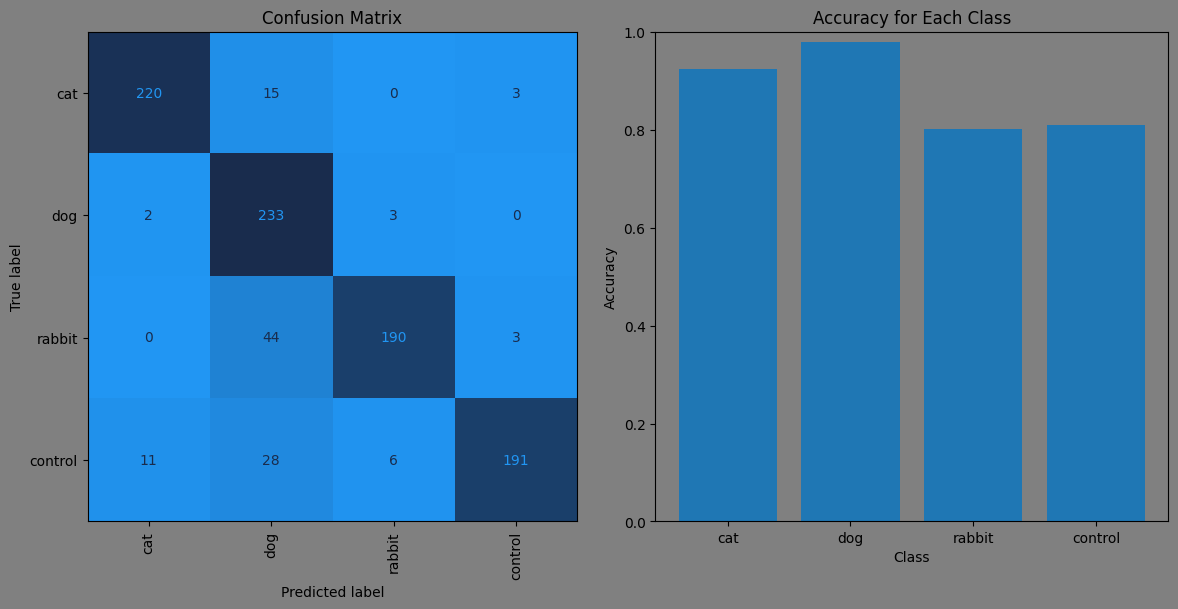

Total correct predictions: 298/1196
Overall accuracy: 0.2492
Correct predictions for cat: 0/299; Accuracy: 0.0000
Correct predictions for dog: 49/298; Accuracy: 0.1644
Correct predictions for rabbit: 0/300; Accuracy: 0.0000
Correct predictions for control: 249/299; Accuracy: 0.8328


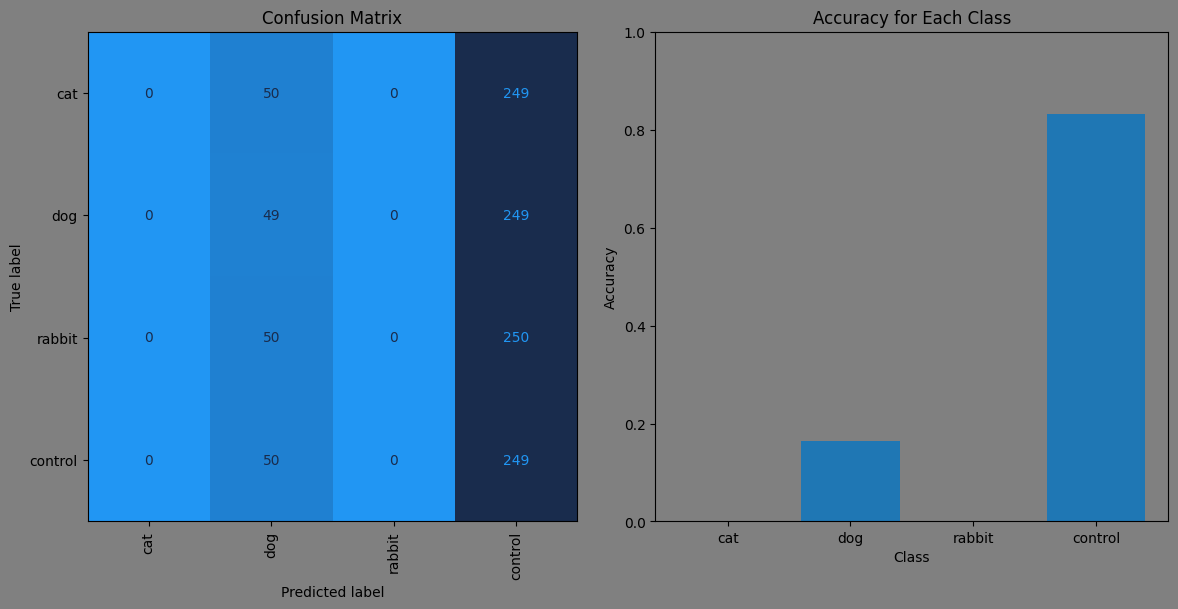

In [43]:
exp3_eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer = optim.Adam(exp3_eegsuperconv.parameters(), lr=0.00001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(exp3_eegsuperconv, 
                                                                        exp3_train_loader, 
                                                                        exp3_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=1000, 
                                                                        patience=100, 
                                                                        verbose=100)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(exp3_eegsuperconv, exp3_train_loader, device,
                        class_names=exp3_dataset.class_mapping.keys())
evaluate_class_metrics(exp3_eegsuperconv, exp3_val_loader, device, print_metrics=False,
                        class_names=exp3_dataset.class_mapping.keys())

# Evaluate on dani
evaluate_class_metrics(exp3_eegsuperconv, dani_loader, device, print_metrics=True,
                        class_names=exp3_dataset.class_mapping.keys())

Epoch [1/200], Train Loss: 55.5762, Train Accuracy: 0.2692, Validation Loss: 91.0745, Validation Accuracy: 0.2687
Epoch [21/200], Train Loss: 1.7353, Train Accuracy: 0.4905, Validation Loss: 1.4713, Validation Accuracy: 0.4868
Epoch [41/200], Train Loss: 1.0556, Train Accuracy: 0.5632, Validation Loss: 0.8964, Validation Accuracy: 0.5922
Epoch [61/200], Train Loss: 0.7866, Train Accuracy: 0.6425, Validation Loss: 0.8203, Validation Accuracy: 0.6481
Epoch [81/200], Train Loss: 0.7841, Train Accuracy: 0.6646, Validation Loss: 0.7249, Validation Accuracy: 0.6523
Epoch [101/200], Train Loss: 0.5297, Train Accuracy: 0.7816, Validation Loss: 0.6475, Validation Accuracy: 0.7597
Epoch [121/200], Train Loss: 0.4755, Train Accuracy: 0.8053, Validation Loss: 0.4278, Validation Accuracy: 0.8535
Epoch [141/200], Train Loss: 0.3829, Train Accuracy: 0.8564, Validation Loss: 0.6510, Validation Accuracy: 0.7924
Epoch [161/200], Train Loss: 0.4608, Train Accuracy: 0.8217, Validation Loss: 0.3769, Valida

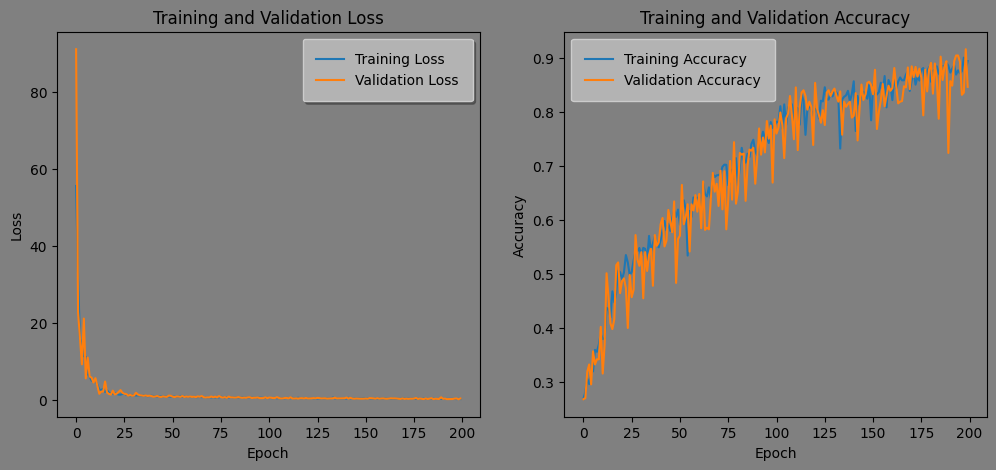

Total correct predictions: 3198/3796
Overall accuracy: 0.8425
Correct predictions for cat: 766/950; Accuracy: 0.8063
Correct predictions for dog: 856/953; Accuracy: 0.8982
Correct predictions for rabbit: 858/950; Accuracy: 0.9032
Correct predictions for control: 718/943; Accuracy: 0.7614


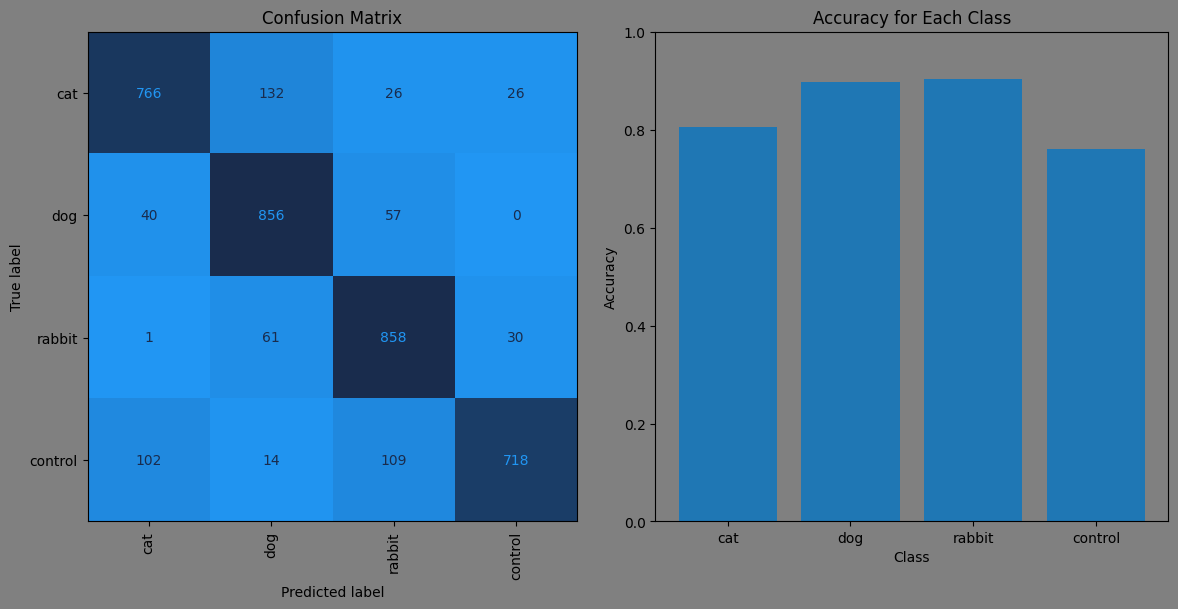

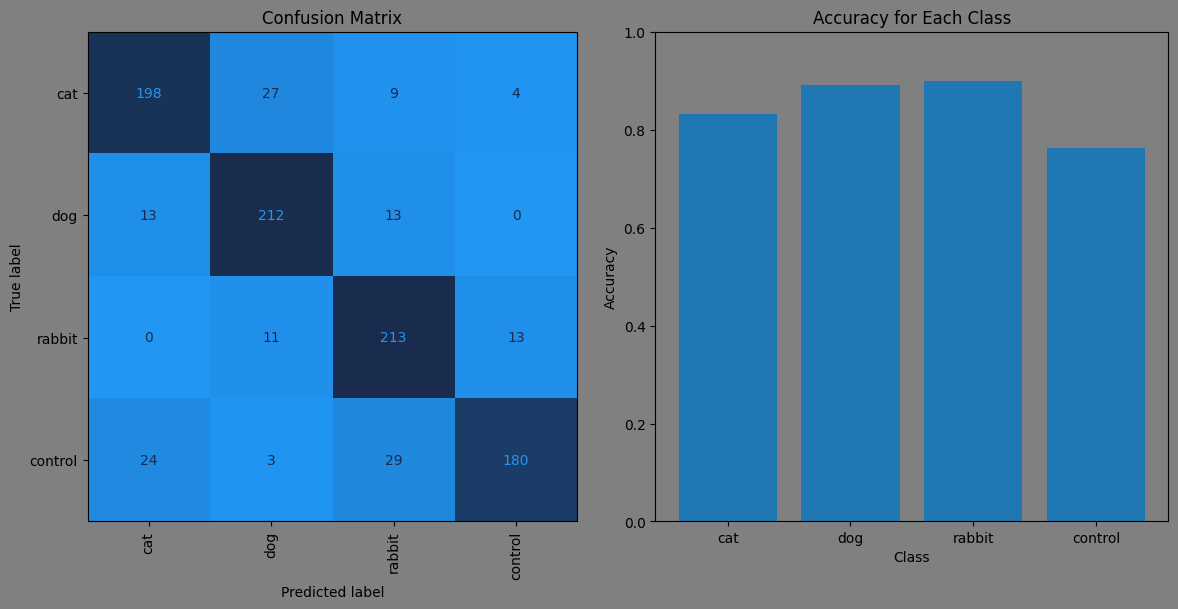

Total correct predictions: 306/1196
Overall accuracy: 0.2559
Correct predictions for cat: 0/299; Accuracy: 0.0000
Correct predictions for dog: 248/298; Accuracy: 0.8322
Correct predictions for rabbit: 58/300; Accuracy: 0.1933
Correct predictions for control: 0/299; Accuracy: 0.0000


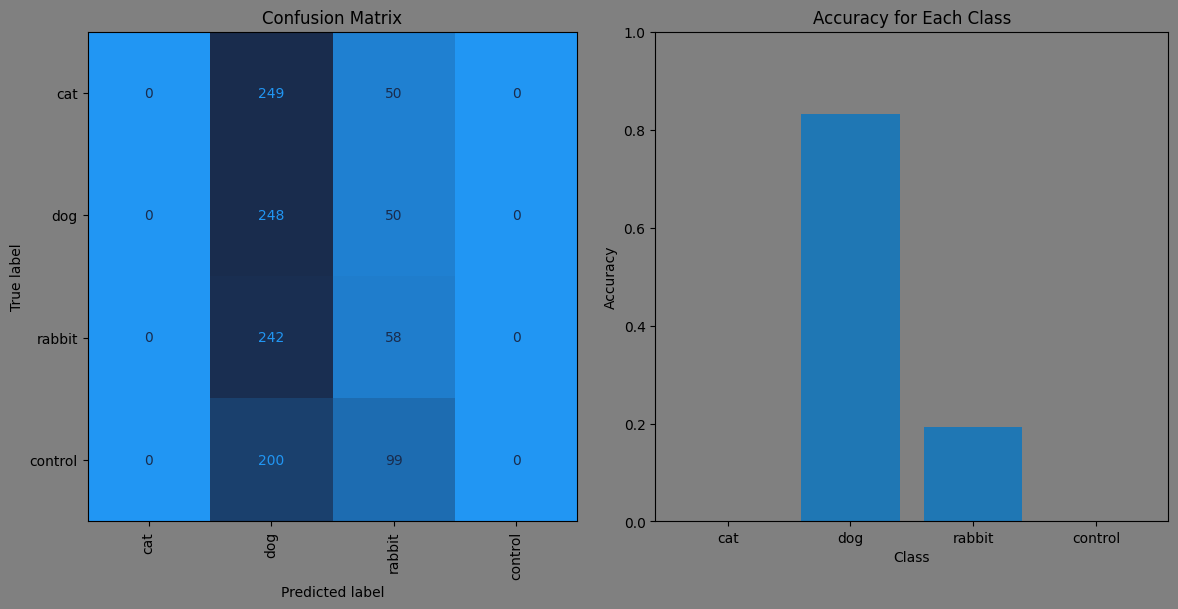

In [45]:
exp3_eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer = optim.Adam(exp3_eegsuperconv.parameters(), lr=0.0001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(exp3_eegsuperconv, 
                                                                        exp3_train_loader, 
                                                                        exp3_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=200, 
                                                                        patience=-1, 
                                                                        verbose=20)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(exp3_eegsuperconv, exp3_train_loader, device,
                        class_names=exp3_dataset.class_mapping.keys())
evaluate_class_metrics(exp3_eegsuperconv, exp3_val_loader, device, print_metrics=False,
                        class_names=exp3_dataset.class_mapping.keys())

# Evaluate on dani
evaluate_class_metrics(exp3_eegsuperconv, dani_loader, device, print_metrics=True,
                        class_names=exp3_dataset.class_mapping.keys())

## Train with pato data predict pato2 data

In [46]:
exp4_pato2_dataset = EEGDataset('SynapSee_data.json', subjects_to_include=['pato2'])
print(len(exp4_pato2_dataset))
exp4_pato_dataset = EEGDataset('SynapSee_data.json', subjects_to_include=['pato'])
print(len(exp4_pato_dataset))
exp4_train_dataset, exp4_val_dataset = stratified_split(exp4_pato_dataset, stratify_by='class')
batch_size = 15
exp4_train_loader = DataLoader(exp4_train_dataset, batch_size=batch_size, shuffle=True)
exp4_val_loader = DataLoader(exp4_val_dataset, batch_size=batch_size, shuffle=True)
exp4_pato2_loader = DataLoader(exp4_pato2_dataset, batch_size=batch_size, shuffle=True)

1198
1183


Epoch [1/200], Train Loss: 60.9771, Train Accuracy: 0.2431, Validation Loss: 17.7758, Validation Accuracy: 0.2616
Epoch [21/200], Train Loss: 7.5771, Train Accuracy: 0.3309, Validation Loss: 4.5968, Validation Accuracy: 0.3629
Epoch [41/200], Train Loss: 2.3479, Train Accuracy: 0.4567, Validation Loss: 2.3660, Validation Accuracy: 0.4388
Epoch [61/200], Train Loss: 2.5735, Train Accuracy: 0.4641, Validation Loss: 3.2079, Validation Accuracy: 0.3840
Epoch [81/200], Train Loss: 1.5855, Train Accuracy: 0.5180, Validation Loss: 1.6735, Validation Accuracy: 0.4810
Epoch [101/200], Train Loss: 1.0335, Train Accuracy: 0.6025, Validation Loss: 1.1946, Validation Accuracy: 0.5612
Epoch [121/200], Train Loss: 0.7600, Train Accuracy: 0.7061, Validation Loss: 0.8657, Validation Accuracy: 0.6540
Epoch [141/200], Train Loss: 0.6963, Train Accuracy: 0.7230, Validation Loss: 0.8354, Validation Accuracy: 0.6962
Epoch [161/200], Train Loss: 0.5711, Train Accuracy: 0.7886, Validation Loss: 1.2158, Valida

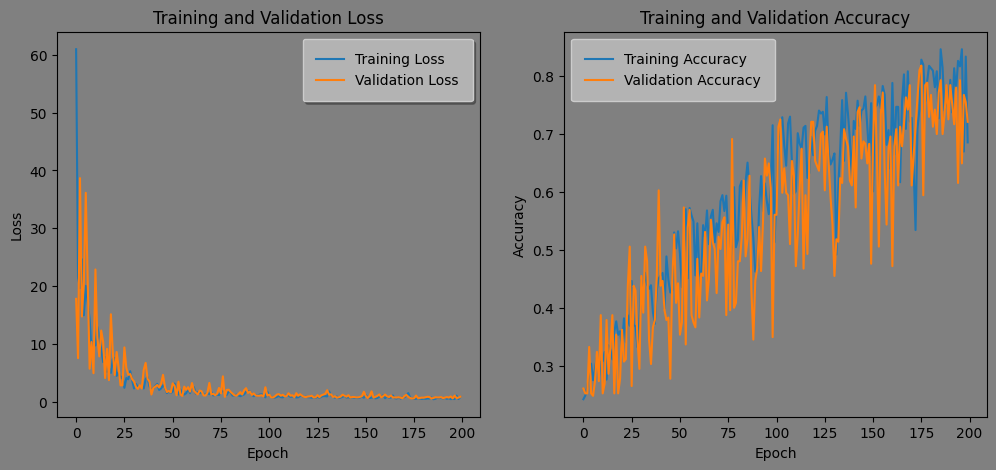

Total correct predictions: 665/946
Overall accuracy: 0.7030
Correct predictions for cat: 158/237; Accuracy: 0.6667
Correct predictions for dog: 202/236; Accuracy: 0.8559
Correct predictions for rabbit: 133/237; Accuracy: 0.5612
Correct predictions for control: 172/236; Accuracy: 0.7288


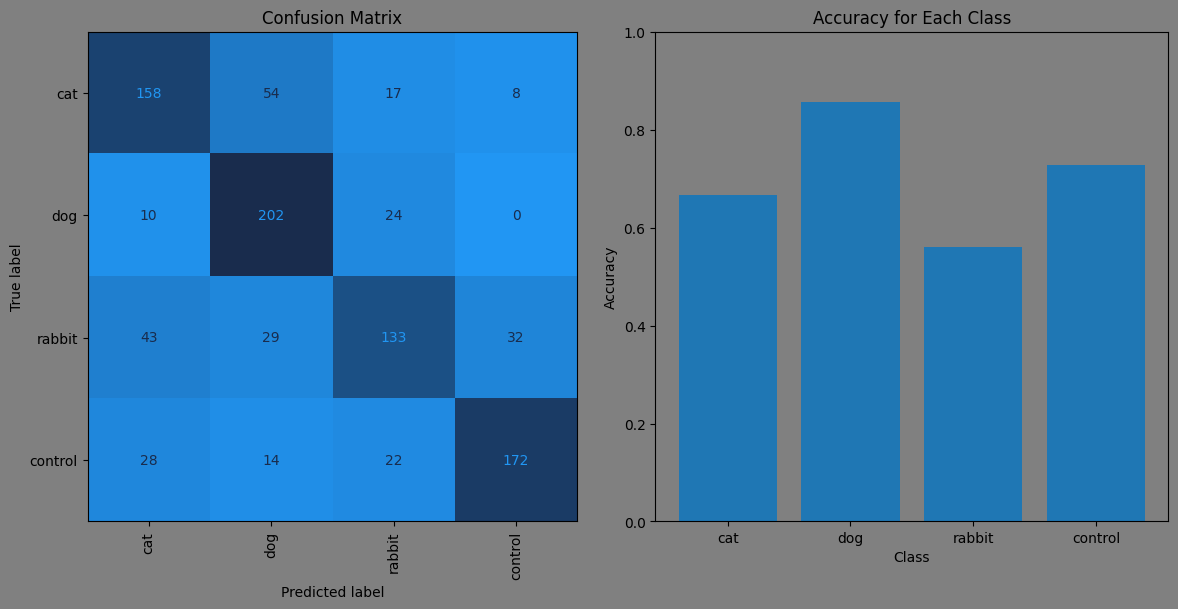

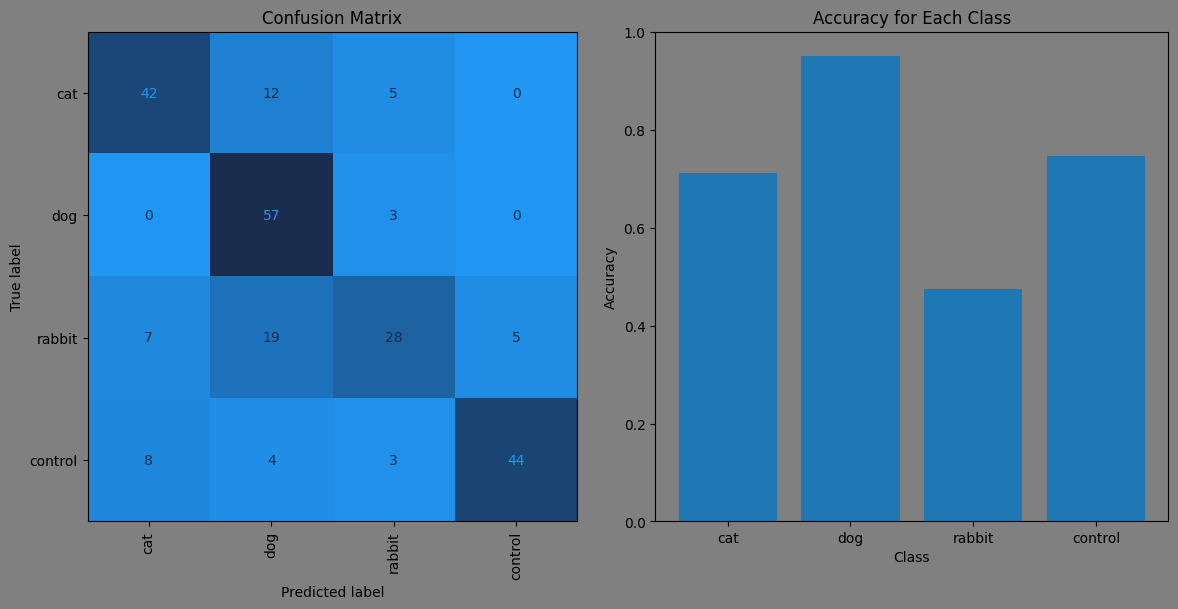

Total correct predictions: 300/1198
Overall accuracy: 0.2504
Correct predictions for cat: 0/299; Accuracy: 0.0000
Correct predictions for dog: 0/300; Accuracy: 0.0000
Correct predictions for rabbit: 300/300; Accuracy: 1.0000
Correct predictions for control: 0/299; Accuracy: 0.0000


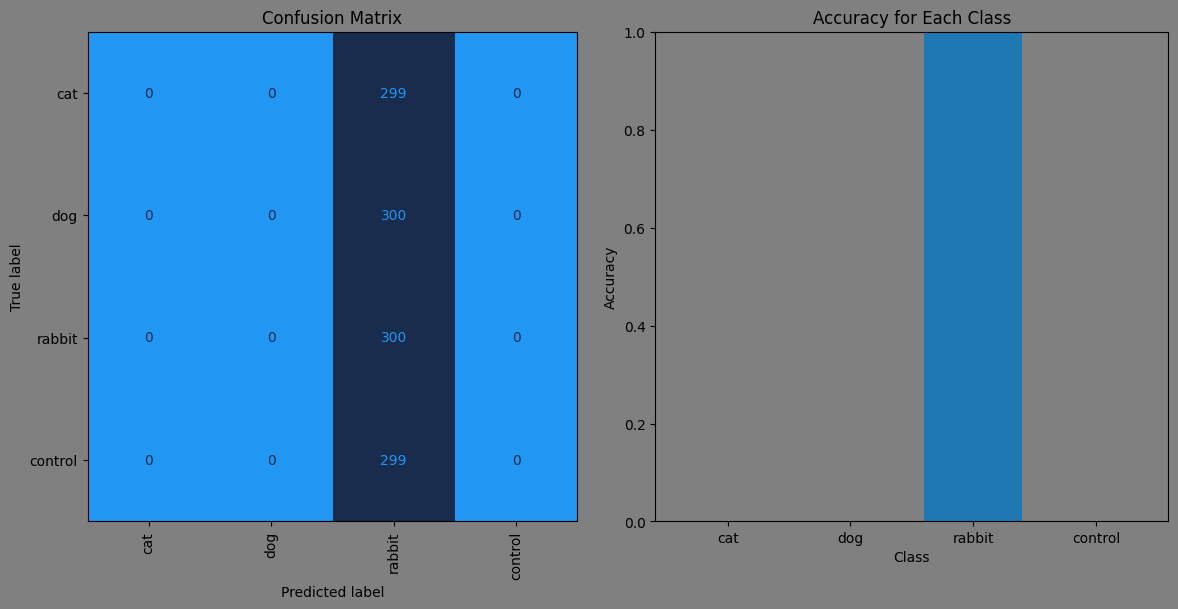

In [47]:
exp4_eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(exp4_eegsuperconv.parameters(), lr=0.0001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(exp4_eegsuperconv, 
                                                                        exp4_train_loader, 
                                                                        exp4_val_loader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=200, 
                                                                        patience=-1, 
                                                                        verbose=20)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate
evaluate_class_metrics(exp4_eegsuperconv, exp4_train_loader, device,
                        class_names=exp4_pato_dataset.class_mapping.keys())
evaluate_class_metrics(exp4_eegsuperconv, exp4_val_loader, device, print_metrics=False,
                        class_names=exp4_pato_dataset.class_mapping.keys())

# Evaluate on pato2
evaluate_class_metrics(exp4_eegsuperconv, exp4_pato2_loader, device, print_metrics=True,
                        class_names=exp4_pato_dataset.class_mapping.keys())


